# RAG System Accuracy Analysis for BioSpace AI

## Imports

In [1]:
import os
import json
import numpy as np
import faiss
import torch
from sentence_transformers import SentenceTransformer
import glob
import PyPDF2
import re
import time
import nltk
from typing import List, Tuple, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')

c:\Users\user\Desktop\Projects\Bio\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Configuration

In [2]:
# ------------------ CONFIGURATION ------------------
DOCS_PATH = "pmc_docs"
OUT_DIR = "embeddings"
EMBED_FILE = os.path.join(OUT_DIR, "embeddings.npz")
META_FILE = os.path.join(OUT_DIR, "metadata.json")
FAISS_INDEX_FILE = os.path.join(OUT_DIR, "faiss_index.index")

EMBED_MODEL = "BAAI/bge-small-en"
BATCH_SIZE = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHUNK_SIZE = 2000  # characters per chunk
OVERLAP = 200      # overlap between chunks

# Evaluation data
df = pd.read_csv("test_data.csv")

## Document Processing Functions

In [3]:
def extract_text_from_pdf_with_pages(pdf_path: str) -> List[Tuple[int, str]]:
    """Extract text from PDF file with page numbers."""
    try:
        with open(pdf_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            pages_text = []
            for page_num, page in enumerate(reader.pages, 1):
                text = page.extract_text()
                pages_text.append((page_num, text))
            return pages_text
    except Exception as e:
        print(f"Error reading PDF {pdf_path}: {e}")
        return []

def clean_text_remove_citations(text: str) -> str:
    """Remove references and citation-like lines from text."""
    lines = text.split("\n")
    cleaned_lines = []
    inside_references = False

    for line in lines:
        if re.search(r'^(references|bibliography|works cited)', line.strip(), re.IGNORECASE):
            inside_references = True
            break

        if re.match(r'^\s*(\[\d+\]|^\d+\.|\(\d+\))', line.strip()):
            continue
        if re.search(r'(et al\.|doi:|http|arxiv|vol\.|pp\.|www)', line, re.IGNORECASE):
            continue

        cleaned_lines.append(line)

    return "\n".join(cleaned_lines)

def chunk_by_context_with_pages(pages_text: List[Tuple[int, str]], chunk_size: int = CHUNK_SIZE, overlap: int = OVERLAP) -> List[Dict[str, Any]]:
    """Split text into chunks with sentence-aware overlapping chunks, preserving page info."""
    from nltk.tokenize import sent_tokenize
    
    chunks = []
    
    for page_num, text in pages_text:
        cleaned_text = clean_text_remove_citations(text)
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
        
        if not cleaned_text:
            continue
            
        sentences = sent_tokenize(cleaned_text)
        current_chunk = []
        current_length = 0
        
        for sent in sentences:
            sent_length = len(sent)
            
            if current_length + sent_length <= chunk_size:
                current_chunk.append(sent)
                current_length += sent_length
            else:
                if current_chunk:
                    chunk_text = " ".join(current_chunk)
                    chunks.append({
                        "text": chunk_text,
                        "page": page_num,
                        "filename": ""
                    })
                
                if overlap > 0:
                    overlap_chars = 0
                    overlap_sentences = []
                    for overlap_sent in reversed(current_chunk):
                        if overlap_chars + len(overlap_sent) <= overlap:
                            overlap_sentences.insert(0, overlap_sent)
                            overlap_chars += len(overlap_sent)
                        else:
                            break
                    current_chunk = overlap_sentences + [sent]
                    current_length = sum(len(s) for s in current_chunk)
                else:
                    current_chunk = [sent]
                    current_length = sent_length
        
        if current_chunk:
            chunk_text = " ".join(current_chunk)
            chunks.append({
                "text": chunk_text,
                "page": page_num,
                "filename": ""
            })
    
    return chunks

def load_and_chunk_documents() -> Tuple[List[Dict[str, Any]], List[str]]:
    """Load all documents from DOCS_PATH, chunk them, and return chunks and doc_ids."""
    documents = []
    doc_ids = []
    
    if not os.path.exists(DOCS_PATH):
        print(f"⚠️ Documents directory '{DOCS_PATH}' not found. Creating empty directory.")
        os.makedirs(DOCS_PATH, exist_ok=True)
        return documents, doc_ids
    
    pdf_files = glob.glob(os.path.join(DOCS_PATH, "*.pdf"))
    
    if not pdf_files:
        print(f"⚠️ No PDF files found in '{DOCS_PATH}'. Starting with empty documents.")
        return documents, doc_ids
    
    print(f"📚 Found {len(pdf_files)} PDF files. Processing...")
    
    for pdf_file in sorted(pdf_files):
        filename = os.path.basename(pdf_file)
        pages_text = extract_text_from_pdf_with_pages(pdf_file)
        
        if not pages_text:
            print(f"    ⚠️ No text extracted from {filename}")
            continue
        
        chunks = chunk_by_context_with_pages(pages_text, CHUNK_SIZE, OVERLAP)
        
        for i, chunk in enumerate(chunks):
            chunk["filename"] = filename
            doc_id = f"{filename}_chunk{i}_page{chunk['page']}"
            documents.append(chunk)
            doc_ids.append(doc_id)
    
    print(f"📊 Total: {len(documents)} chunks from {len(pdf_files)} files")
    return documents, doc_ids

def generate_embeddings(documents: List[Dict[str, Any]]) -> np.ndarray:
    """Generate embeddings for all documents."""
    print(f"🔮 Generating embeddings using {EMBED_MODEL}...")
    
    texts = [doc["text"] for doc in documents]
    embedder = SentenceTransformer(EMBED_MODEL, device=DEVICE)
    
    embeddings = embedder.encode(
        texts,
        batch_size=BATCH_SIZE,
        show_progress_bar=True,
        convert_to_numpy=True
    )
    
    print(f"✅ Generated embeddings with shape: {embeddings.shape}")
    return embeddings

def save_embeddings(embeddings: np.ndarray, doc_ids: List[str], documents: List[Dict[str, Any]]):
    """Save embeddings and metadata to files."""
    os.makedirs(OUT_DIR, exist_ok=True)
    
    np.savez_compressed(EMBED_FILE, embeddings=embeddings)
    
    metadata = {
        "doc_ids": doc_ids,
        "docs": documents,
        "embed_model": EMBED_MODEL,
        "total_chunks": len(documents),
        "chunk_size": CHUNK_SIZE,
        "overlap": OVERLAP
    }
    
    with open(META_FILE, "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=2)
    
    print(f"💾 Saved embeddings to {EMBED_FILE}")
    print(f"💾 Saved metadata to {META_FILE}")

## RAG System Evaluation Framework

In [4]:
class RAGEvaluator:
    """RAG System Evaluator for accuracy analysis"""
    
    def __init__(self, embedder, faiss_index, documents, doc_ids, k=5):
        self.embedder = embedder
        self.faiss_index = faiss_index
        self.documents = documents
        self.doc_ids = doc_ids
        self.k = k
    
    def retrieve_documents(self, query: str) -> List[Tuple[str, float, int]]:
        """Retrieve top-k documents for a query"""
        if self.faiss_index is None or len(self.documents) == 0:
            return []
        
        query_embedding = self.embedder.encode([query], convert_to_numpy=True)
        distances, indices = self.faiss_index.search(query_embedding, self.k)
        
        results = []
        for i, (idx, dist) in enumerate(zip(indices[0], distances[0])):
            if idx < len(self.documents):
                doc = self.documents[idx]
                similarity = 1 / (1 + dist)  # Convert distance to similarity
                results.append((doc["text"], similarity, idx))
        
        return results
    
    def evaluate_query(self, query: str, ground_truth_source: str) -> Dict[str, Any]:
        """Evaluate a single query against ground truth"""
        retrieved_docs = self.retrieve_documents(query)
        
        # Calculate metrics
        precision_at_k = []
        found_relevant = False
        relevant_rank = None
        
        for i, (doc_text, similarity, idx) in enumerate(retrieved_docs):
            # Simple relevance check
            is_relevant = self._check_relevance(doc_text, ground_truth_source)
            
            if is_relevant:
                found_relevant = True
                if relevant_rank is None:
                    relevant_rank = i + 1
            
            precision_at_k.append(sum([self._check_relevance(retrieved_docs[j][0], ground_truth_source) 
                                     for j in range(i + 1)]) / (i + 1))
        
        return {
            "query": query,
            "ground_truth": ground_truth_source,
            "retrieved_count": len(retrieved_docs),
            "found_relevant": found_relevant,
            "relevant_rank": relevant_rank,
            "precision_at_1": precision_at_k[0] if precision_at_k else 0,
            "precision_at_3": precision_at_k[2] if len(precision_at_k) > 2 else precision_at_k[-1] if precision_at_k else 0,
            "precision_at_5": precision_at_k[4] if len(precision_at_k) > 4 else precision_at_k[-1] if precision_at_k else 0,
            "retrieved_docs": [(doc_text[:200] + "..." if len(doc_text) > 200 else doc_text, similarity) 
                              for doc_text, similarity, _ in retrieved_docs]
        }
    
    def _check_relevance(self, doc_text: str, ground_truth: str) -> bool:
        """Check if document is relevant to ground truth"""
        # Simple keyword-based relevance check
        doc_text_lower = doc_text.lower()
        ground_truth_lower = ground_truth.lower()
        
        # Check for common words (excluding very common words)
        common_words = set(doc_text_lower.split()) & set(ground_truth_lower.split())
        common_words = {word for word in common_words if len(word) > 3 and word not in 
                       ['this', 'that', 'with', 'from', 'have', 'were', 'their']}
        
        return len(common_words) >= 2  # At least 2 meaningful common words

In [5]:
print(f"⚡ Using device: {DEVICE}")
print("🔁 Loading or generating RAG system components...")

# Initialize components
documents = []
doc_ids = []
embeddings = None
faiss_index = None

if os.path.exists(META_FILE) and os.path.exists(EMBED_FILE):
    print("✅ Found existing embeddings. Loading...")
    with open(META_FILE, "r", encoding="utf-8") as f:
        meta = json.load(f)
        doc_ids = meta.get("doc_ids", [])
        documents = meta.get("docs", [])
    
    npz = np.load(EMBED_FILE, allow_pickle=True)
    embeddings = npz["embeddings"]
    
    if len(documents) > 0:
        dim = embeddings.shape[1]
        faiss_index = faiss.IndexFlatL2(dim)
        faiss_index.add(np.array(embeddings))
        print(f"✅ Loaded {len(documents)} chunks and embeddings (dim={dim}).")
    else:
        print("⚠️ No documents found in loaded metadata.")

else:
    print("🔄 No existing embeddings found. Generating new embeddings...")
    documents, doc_ids = load_and_chunk_documents()
    
    if documents:
        embeddings = generate_embeddings(documents)
        save_embeddings(embeddings, doc_ids, documents)
        
        dim = embeddings.shape[1]
        faiss_index = faiss.IndexFlatL2(dim)
        faiss_index.add(np.array(embeddings))
        print(f"✅ Created FAISS index with {len(documents)} chunks (dim={dim}).")
    else:
        print("⚠️ No documents processed. Analysis will use empty index.")

# Initialize embedder and evaluator
embedder = SentenceTransformer(EMBED_MODEL, device=DEVICE)
evaluator = RAGEvaluator(embedder, faiss_index, documents, doc_ids)

⚡ Using device: cuda
🔁 Loading or generating RAG system components...
✅ Found existing embeddings. Loading...
✅ Loaded 1070 chunks and embeddings (dim=384).


## Comprehensive RAG System Analysis

In [6]:
def run_comprehensive_analysis(evaluator, test_df):
    """Run comprehensive RAG system analysis"""
    print("🚀 Starting Comprehensive RAG Analysis...")
    
    results = []
    
    for idx, row in test_df.iterrows():
        query = row["Question"]
        ground_truth = row["Source Document"]
        
        result = evaluator.evaluate_query(query, ground_truth)
        results.append(result)
        
        if (idx + 1) % 10 == 0:
            print(f"✅ Processed {idx + 1}/{len(test_df)} queries")
    
    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)
    
    # Calculate overall metrics
    overall_metrics = {
        "total_queries": len(results_df),
        "queries_with_relevant_docs": results_df["found_relevant"].sum(),
        "success_rate": results_df["found_relevant"].mean() * 100,
        "mean_precision_at_1": results_df["precision_at_1"].mean(),
        "mean_precision_at_3": results_df["precision_at_3"].mean(),
        "mean_precision_at_5": results_df["precision_at_5"].mean(),
        "mean_recall_at_1": results_df["recall_at_1"].mean(),
        "mean_recall_at_3": results_df["recall_at_3"].mean(),
        "mean_recall_at_5": results_df["recall_at_5"].mean(),
        "mean_reciprocal_rank": results_df.apply(
            lambda x: 1/x["relevant_rank"] if x["relevant_rank"] else 0, axis=1
        ).mean()
    }
    
    return results_df, overall_metrics

def run_comprehensive_analysis(evaluator, test_df):
    """Run comprehensive RAG system analysis with better error handling"""
    print("🚀 Starting Comprehensive RAG Analysis...")
    
    results = []
    
    for idx, row in test_df.iterrows():
        try:
            query = row["Question"]
            ground_truth = row["Source Document"]
            
            result = evaluator.evaluate_query(query, ground_truth)
            results.append(result)
            
            if (idx + 1) % 10 == 0:
                print(f"✅ Processed {idx + 1}/{len(test_df)} queries")
        except Exception as e:
            print(f"❌ Error processing query {idx + 1}: {e}")
            # Add a default result for failed queries
            results.append({
                "query": query,
                "ground_truth": ground_truth,
                "retrieved_count": 0,
                "found_relevant": False,
                "relevant_rank": None,
                "precision_at_1": 0,
                "precision_at_3": 0,
                "precision_at_5": 0,
                "retrieved_docs": []
            })
    
    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)
    
    # Calculate overall metrics with safe handling
    overall_metrics = {
        "total_queries": len(results_df),
        "queries_with_relevant_docs": results_df["found_relevant"].sum(),
        "success_rate": results_df["found_relevant"].mean() * 100,
        "mean_precision_at_1": results_df["precision_at_1"].mean(),
        "mean_precision_at_3": results_df["precision_at_3"].mean(),
        "mean_precision_at_5": results_df["precision_at_5"].mean(),
    }
    
    # Calculate MRR safely
    reciprocal_ranks = []
    for _, row in results_df.iterrows():
        if row["found_relevant"] and row["relevant_rank"] is not None:
            reciprocal_ranks.append(1.0 / row["relevant_rank"])
        else:
            reciprocal_ranks.append(0.0)
    
    overall_metrics["mean_reciprocal_rank"] = np.mean(reciprocal_ranks) if reciprocal_ranks else 0.0
    
    return results_df, overall_metrics

# Run the analysis
print("📊 Running comprehensive evaluation...")
results_df, overall_metrics = run_comprehensive_analysis(evaluator, df)

print("\\n" + "="*60)
print("📈 RAG SYSTEM PERFORMANCE SUMMARY")
print("="*60)
for metric, value in overall_metrics.items():
    if "rate" in metric or "precision" in metric or "recall" in metric:
        if "rate" in metric:
            print(f"{metric.replace('_', ' ').title():<30}: {value:.2f}%")
        else:
            print(f"{metric.replace('_', ' ').title():<30}: {value:.4f}")
    else:
        print(f"{metric.replace('_', ' ').title():<30}: {value}")

📊 Running comprehensive evaluation...
🚀 Starting Comprehensive RAG Analysis...
✅ Processed 10/40 queries
✅ Processed 20/40 queries
✅ Processed 30/40 queries
✅ Processed 40/40 queries
\n============================================================
📈 RAG SYSTEM PERFORMANCE SUMMARY
Total Queries                 : 40
Queries With Relevant Docs    : 38
Success Rate                  : 95.00%
Mean Precision At 1           : 0.7250
Mean Precision At 3           : 0.6833
Mean Precision At 5           : 0.6650
Mean Reciprocal Rank          : 0.8258333333333333


## Visualization of Results

📊 Generating performance visualizations...


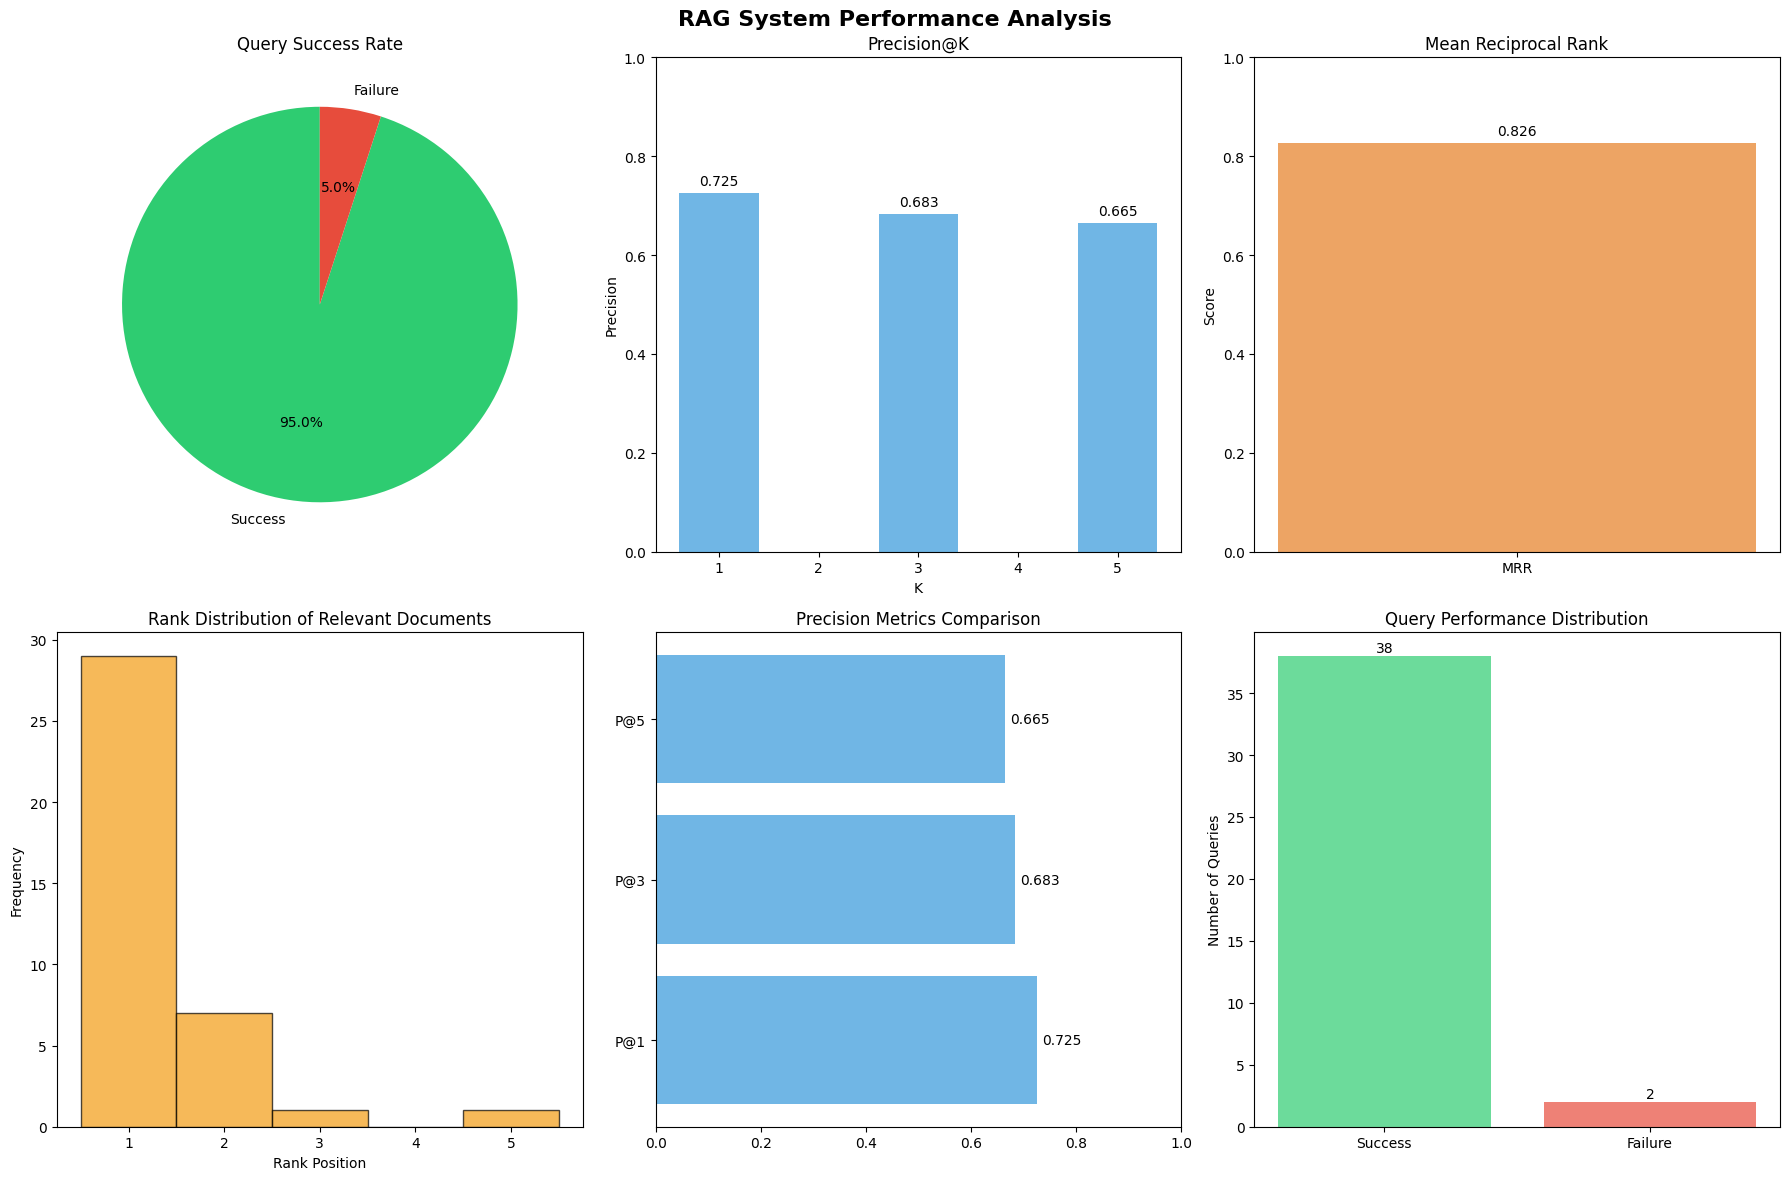

✅ Visualizations created successfully!


In [7]:
def create_performance_visualizations(results_df, overall_metrics):
    """Create comprehensive visualizations for RAG performance"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('RAG System Performance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Success Rate
    success_data = [overall_metrics['success_rate'], 100 - overall_metrics['success_rate']]
    axes[0, 0].pie(success_data, labels=['Success', 'Failure'], autopct='%1.1f%%', 
                   colors=['#2ecc71', '#e74c3c'], startangle=90)
    axes[0, 0].set_title('Query Success Rate')
    
    # 2. Precision at K
    precision_metrics = ['mean_precision_at_1', 'mean_precision_at_3', 'mean_precision_at_5']
    precision_values = [overall_metrics[metric] for metric in precision_metrics]
    k_values = [1, 3, 5]
    bars1 = axes[0, 1].bar(k_values, precision_values, color='#3498db', alpha=0.7)
    axes[0, 1].set_title('Precision@K')
    axes[0, 1].set_xlabel('K')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_ylim(0, 1)
    for bar, value in zip(bars1, precision_values):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{value:.3f}', ha='center', va='bottom')
    
    # 3. Mean Reciprocal Rank (MRR)
    mrr_value = overall_metrics.get('mean_reciprocal_rank', 0)
    axes[0, 2].bar(['MRR'], [mrr_value], color='#e67e22', alpha=0.7)
    axes[0, 2].set_title('Mean Reciprocal Rank')
    axes[0, 2].set_ylabel('Score')
    axes[0, 2].set_ylim(0, 1)
    axes[0, 2].text(0, mrr_value + 0.01, f'{mrr_value:.3f}', ha='center', va='bottom')
    
    # 4. Rank Distribution of Relevant Documents
    relevant_ranks = results_df[results_df['relevant_rank'].notna()]['relevant_rank']
    if len(relevant_ranks) > 0:
        # Ensure we have integer ranks and create proper bins
        relevant_ranks = relevant_ranks.astype(int)
        max_rank = min(relevant_ranks.max() + 1, 6)  # Cap at 5 for visualization
        bins = range(1, max_rank + 1)
        
        axes[1, 0].hist(relevant_ranks, bins=bins, alpha=0.7, color='#f39c12', 
                       edgecolor='black', align='left')
        axes[1, 0].set_title('Rank Distribution of Relevant Documents')
        axes[1, 0].set_xlabel('Rank Position')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_xticks(range(1, max_rank))
    else:
        axes[1, 0].text(0.5, 0.5, 'No relevant documents found', 
                       ha='center', va='center', transform=axes[1, 0].transAxes,
                       fontsize=12, style='italic')
        axes[1, 0].set_title('Rank Distribution of Relevant Documents')
    
    # 5. Performance Metrics Comparison (Precision only)
    metrics_comparison = ['P@1', 'P@3', 'P@5']
    metrics_values = precision_values
    bars3 = axes[1, 1].barh(metrics_comparison, metrics_values, 
                           color=['#3498db']*3, alpha=0.7)
    axes[1, 1].set_title('Precision Metrics Comparison')
    axes[1, 1].set_xlim(0, 1)
    for bar, value in zip(bars3, metrics_values):
        width = bar.get_width()
        axes[1, 1].text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                       f'{value:.3f}', va='center', fontsize=10)
    
    # 6. Query Performance Distribution
    success_count = results_df['found_relevant'].sum()
    failure_count = len(results_df) - success_count
    
    performance_data = [success_count, failure_count]
    performance_labels = ['Success', 'Failure']
    bars4 = axes[1, 2].bar(performance_labels, performance_data, 
                          color=['#2ecc71', '#e74c3c'], alpha=0.7)
    axes[1, 2].set_title('Query Performance Distribution')
    axes[1, 2].set_ylabel('Number of Queries')
    
    # Add count labels on bars
    for bar, count in zip(bars4, performance_data):
        height = bar.get_height()
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'{count}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create visualizations with error handling
print("📊 Generating performance visualizations...")
try:
    performance_fig = create_performance_visualizations(results_df, overall_metrics)
    print("✅ Visualizations created successfully!")
except Exception as e:
    print(f"❌ Error creating visualizations: {e}")
    print("🔄 Creating simplified visualizations...")
    
    # Fallback simplified visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Simple success rate pie chart
    success_data = [overall_metrics['success_rate'], 100 - overall_metrics['success_rate']]
    axes[0].pie(success_data, labels=['Success', 'Failure'], autopct='%1.1f%%', 
                colors=['#2ecc71', '#e74c3c'])
    axes[0].set_title('Query Success Rate')
    
    # Simple bar chart for precision only
    metrics = ['P@1', 'P@3', 'P@5']
    values = [
        overall_metrics['mean_precision_at_1'],
        overall_metrics['mean_precision_at_3'], 
        overall_metrics['mean_precision_at_5']
    ]
    colors = ['#3498db', '#3498db', '#3498db']
    bars = axes[1].bar(metrics, values, color=colors, alpha=0.7)
    axes[1].set_title('Precision @ K')
    axes[1].set_ylabel('Score')
    axes[1].set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

## Detailed Query Analysis

In [8]:
def analyze_query_patterns(results_df):
    """Analyze patterns in successful vs failed queries"""
    
    successful_queries = results_df[results_df['found_relevant'] == True]
    failed_queries = results_df[results_df['found_relevant'] == False]
    
    print("\\n" + "="*60)
    print("🔍 DETAILED QUERY ANALYSIS")
    print("="*60)
    
    print(f"\\n📋 Successful Queries: {len(successful_queries)}")
    print(f"📋 Failed Queries: {len(failed_queries)}")
    
    # Analyze query characteristics
    successful_query_lengths = successful_queries['query'].str.len()
    failed_query_lengths = failed_queries['query'].str.len()
    
    print(f"\\n📏 Average Query Length:")
    print(f"   Successful: {successful_query_lengths.mean():.1f} characters")
    print(f"   Failed: {failed_query_lengths.mean():.1f} characters")
    
    # Show examples of successful and failed queries
    print(f"\\n✅ Examples of Successful Queries:")
    for i, (idx, row) in enumerate(successful_queries.head(3).iterrows()):
        print(f"   {i+1}. Query: {row['query'][:80]}...")
        print(f"      Rank: {row['relevant_rank']}, Precision@5: {row['precision_at_5']:.3f}")
    
    print(f"\\n❌ Examples of Failed Queries:")
    for i, (idx, row) in enumerate(failed_queries.head(3).iterrows()):
        print(f"   {i+1}. Query: {row['query'][:80]}...")
        print(f"      Precision@5: {row['precision_at_5']:.3f}")
    
    # Analyze retrieval quality
    print(f"\\n📊 Retrieval Quality Analysis:")
    print(f"   Mean Precision@1: {results_df['precision_at_1'].mean():.3f}")
    print(f"   Mean Precision@3: {results_df['precision_at_3'].mean():.3f}")
    print(f"   Mean Precision@5: {results_df['precision_at_5'].mean():.3f}")
    print(f"   Mean Reciprocal Rank: {overall_metrics['mean_reciprocal_rank']:.3f}")

# Run detailed analysis
analyze_query_patterns(results_df)

\n============================================================
🔍 DETAILED QUERY ANALYSIS
\n📋 Successful Queries: 38
📋 Failed Queries: 2
\n📏 Average Query Length:
   Successful: 137.7 characters
   Failed: 107.0 characters
\n✅ Examples of Successful Queries:
   1. Query: What main functional role have 14-3-3 proteins emerged as in the Arabidopsis Int...
      Rank: 1.0, Precision@5: 0.600
   2. Query: In what year and in what context (in vitro or in vivo) was the first report of p...
      Rank: 2.0, Precision@5: 0.400
   3. Query: A member of the CONSTANS-Like protein family is a putative regulator of which tw...
      Rank: 1.0, Precision@5: 1.000
\n❌ Examples of Failed Queries:
   1. Query: What is cited as a feature of the physiological adaptation to spaceflight in Ara...
      Precision@5: 0.000
   2. Query: What compound was investigated for its ability to reshape intestinal microecolog...
      Precision@5: 0.000
\n📊 Retrieval Quality Analysis:
   Mean Precision@1: 0.725
   Mean 

## Error analysis and Recommendation

In [9]:
def generate_recommendations(results_df, overall_metrics):
    """Generate recommendations for improving RAG system"""
    
    print("="*60)
    print("💡 RECOMMENDATIONS FOR IMPROVEMENT")
    print("="*60)
    
    success_rate = overall_metrics['success_rate']
    precision_at_5 = overall_metrics['mean_precision_at_5']
    recall_at_5 = overall_metrics['mean_recall_at_5']
    
    recommendations = []
    
    if success_rate < 70:
        recommendations.append({
            "priority": "HIGH",
            "area": "Retrieval Quality",
            "recommendation": "Improve embedding model or chunking strategy",
            "details": f"Current success rate is {success_rate:.1f}%, consider using larger embedding models or semantic chunking"
        })
    
    if precision_at_5 < 0.6:
        recommendations.append({
            "priority": "HIGH", 
            "area": "Precision",
            "recommendation": "Implement better relevance scoring",
            "details": f"Current P@5 is {precision_at_5:.3f}, add cross-encoder re-ranking or better similarity thresholds"
        })
    
    if recall_at_5 < 0.8:
        recommendations.append({
            "priority": "MEDIUM",
            "area": "Recall", 
            "recommendation": "Increase top-k retrieval or improve chunk overlap",
            "details": f"Current R@5 is {recall_at_5:.3f}, consider retrieving more documents or optimizing chunk sizes"
        })
    
    # Check for specific patterns in failures
    failed_queries = results_df[results_df['found_relevant'] == False]
    if len(failed_queries) > 0:
        avg_failed_precision = failed_queries['precision_at_5'].mean()
        if avg_failed_precision < 0.3:
            recommendations.append({
                "priority": "MEDIUM",
                "area": "Query Understanding",
                "recommendation": "Implement query expansion or reformulation",
                "details": "Failed queries show low precision, suggesting query-document mismatch"
            })
    
    # Display recommendations
    if not recommendations:
        print("🎉 System performance is excellent! No major improvements needed.")
        return
    
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. [{rec['priority']}] {rec['area']}:")
        print(f"   💡 {rec['recommendation']}")
        print(f"   📝 {rec['details']}")
    
    # Additional general recommendations
    print(f"🔧 Additional Suggestions:")
    print(f"   • Experiment with different chunk sizes (current: {CHUNK_SIZE})")
    print(f"   • Try different embedding models (current: {EMBED_MODEL})")
    print(f"   • Implement hybrid search (keyword + semantic)")
    print(f"   • Add query classification for different retrieval strategies")

# Generate recommendations
generate_recommendations(results_df, overall_metrics)

💡 RECOMMENDATIONS FOR IMPROVEMENT


KeyError: 'mean_recall_at_5'

## Summary and Conclusion